In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

In [2]:
import torch
import torch.optim as optim
from model import LogisticRegressionModule
from data import get_dataloaders
from l2d_functionality.l2d_loss import L2D_Loss
from l2d_functionality.l2d_eval import L2D_Eval
import numpy as np
import matplotlib.pyplot as plt

In [3]:
input_dim = 28 * 28
num_classes = 10
learning_rate = 0.00005
num_epochs = 5
l2_lambda = 0.5
expert_prob = 0.9

In [4]:
output_dim = num_classes + 1
deferral_class_index = num_classes

In [5]:
# loss_type = "softmax"
# loss_type = "one_vs_all"
# loss_type = "asymmetric_sm"
# loss_type = "realizable_sm"

In [6]:
# load data

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from data import ExpertMNIST

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda tensor: torch.flatten(tensor)) # Flatten the tensor
])

train_dataset_raw = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset_raw = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

expert = ExpertMNIST(expert_prob)

expert_labels_train = torch.tensor([expert.expert_prediction(label) for _, label in train_dataset_raw])
expert_labels_test = torch.tensor([expert.expert_prediction(label) for _, label in test_dataset_raw])

In [7]:
model = LogisticRegressionModule(input_dim, output_dim, deferral_class_index, l2_lambda)
train_loader, test_loader = get_dataloaders(train_dataset_raw, expert_labels_train, test_dataset_raw, expert_labels_test)

In [8]:
l2d = L2D_Loss(num_classes)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

for epoch in range(int(num_epochs)):

    for images, labels, expert_labels_batch in train_loader:
        outputs = model(images)
        
        loss = l2d.loss_fn(outputs, labels, expert_labels_batch, deferral_class_index, "asymmetric_sm")

        loss += model.l2_regularization()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())


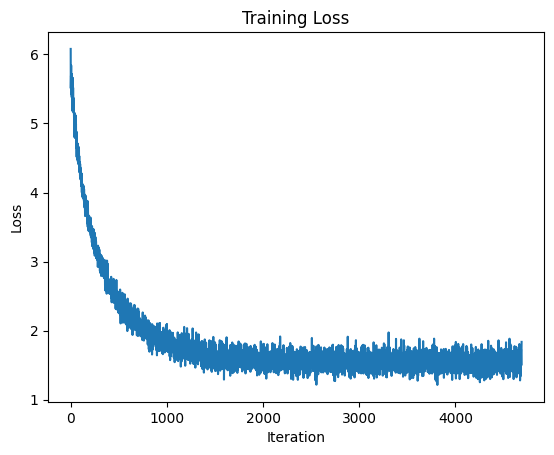

In [9]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.savefig("training_loss.png")

Test Accuracy of Regular Classifier: 87.32%
Test Accuracy (excluding deferrals): 91.91%
Deferral Accuracy: 77.36%
Overall Deferral Rate: 47.44%
Overall L2D Accuracy: 85.01%
Class 0: Accuracy (non-deferred) = 97.51%, Deferral Rate = 5.92%, Overall Accuracy = 91.73%
Class 1: Accuracy (non-deferred) = 96.30%, Deferral Rate = 61.94%, Overall Accuracy = 93.30%
Class 2: Accuracy (non-deferred) = 87.19%, Deferral Rate = 12.98%, Overall Accuracy = 75.87%
Class 3: Accuracy (non-deferred) = 91.44%, Deferral Rate = 78.02%, Overall Accuracy = 93.17%
Class 4: Accuracy (non-deferred) = 94.95%, Deferral Rate = 27.39%, Overall Accuracy = 68.94%
Class 5: Accuracy (non-deferred) = 77.57%, Deferral Rate = 70.52%, Overall Accuracy = 90.13%
Class 6: Accuracy (non-deferred) = 94.14%, Deferral Rate = 3.86%, Overall Accuracy = 90.50%
Class 7: Accuracy (non-deferred) = 82.80%, Deferral Rate = 90.95%, Overall Accuracy = 96.01%
Class 8: Accuracy (non-deferred) = 91.53%, Deferral Rate = 41.79%, Overall Accuracy =

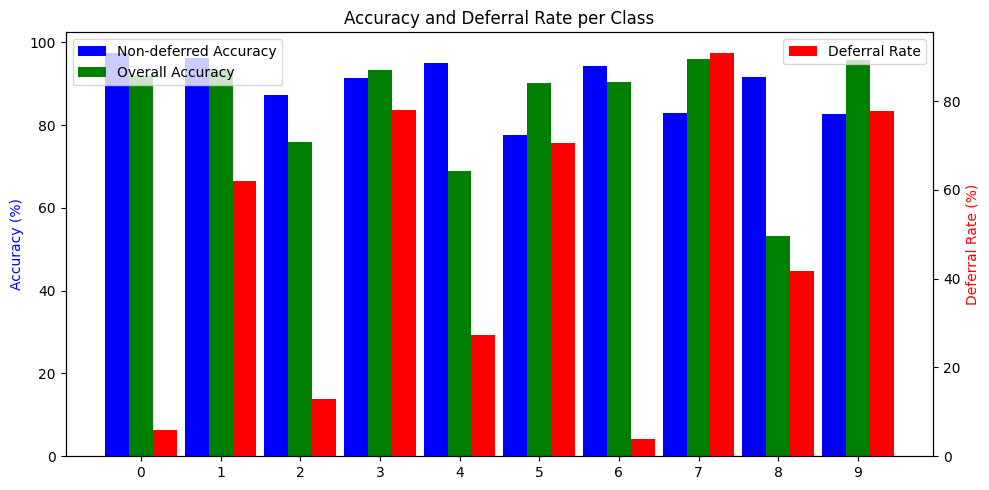

In [10]:
# eval 

all_outputs = []
all_labels = []
all_expert_labels = []

with torch.no_grad():
    for images, labels, expert_labels in test_loader:

        outputs = model(images)
        all_outputs.append(outputs)
        all_labels.append(labels)
        all_expert_labels.append(expert_labels)

all_outputs = torch.cat(all_outputs, dim=0)
all_labels = torch.cat(all_labels, dim=0)
all_expert_labels = torch.cat(all_expert_labels, dim=0)

l2d_eval = L2D_Eval(num_classes, all_outputs, all_labels, all_expert_labels, deferral_class_index)

model_report = l2d_eval.model_report()
per_class_report = l2d_eval.per_class_report()
l2d_eval.visualize_per_class_metrics()

In [11]:
print(model_report)

{'Test Accuracy of Regular Classifier': 87.32, 'Test Accuracy (excluding deferrals)': 91.91400304414003, 'Deferral Accuracy': 77.36087689713322, 'Overall Deferral Rate': 47.44, 'Overall L2D Accuracy': 85.01}


In [12]:
print(per_class_report)

{0: {'accuracy_nondeferred': 97.5054229934924, 'deferral_rate': 5.918367346938775, 'overall_accuracy': 91.73469387755102}, 1: {'accuracy_nondeferred': 96.29629629629629, 'deferral_rate': 61.93832599118943, 'overall_accuracy': 93.30396475770925}, 2: {'accuracy_nondeferred': 87.19376391982182, 'deferral_rate': 12.984496124031008, 'overall_accuracy': 75.87209302325581}, 3: {'accuracy_nondeferred': 91.44144144144144, 'deferral_rate': 78.01980198019803, 'overall_accuracy': 93.16831683168317}, 4: {'accuracy_nondeferred': 94.95091164095372, 'deferral_rate': 27.39307535641548, 'overall_accuracy': 68.94093686354378}, 5: {'accuracy_nondeferred': 77.56653992395437, 'deferral_rate': 70.51569506726457, 'overall_accuracy': 90.13452914798206}, 6: {'accuracy_nondeferred': 94.13680781758957, 'deferral_rate': 3.862212943632568, 'overall_accuracy': 90.50104384133611}, 7: {'accuracy_nondeferred': 82.79569892473118, 'deferral_rate': 90.95330739299611, 'overall_accuracy': 96.01167315175097}, 8: {'accuracy_n